### Load dala from files

In [1]:
import os
import json

FILE_PATH = 'data/glassdoor_us/'

def get_body(path):
    return json.load(open(path, 'r'))['body']

data = [get_body(FILE_PATH + file) for file in os.listdir(FILE_PATH) if file[-4:] == 'json']

N_DOCUMENTS = len(data)
N_DOCUMENTS

955

### Load buzzword dictionary

In [2]:
buzz_words = {}
for raw_line in open('java_buzzwords.txt', 'r'):
    line = raw_line.strip().lower()
    
    # skip empty line or comment
    if len(line) == 0 or line[0] == '#':
        continue
    
    # add synnonyms to dictionary
    tokens = line.split('|')
    label = tokens[0]
    for key in tokens:
        buzz_words[key] = label
        

### Find buzzwords in documents

In [3]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[\w\-\#\+]+')
buzzword_keys = set(buzz_words.keys())

def replace_ngrams(doc):
    result = doc
    for key, value in buzz_words.items():
        if ' ' in key and key in result:
            result = result.replace(key, value)
            
    return result

def find_buzzwords(doc):
    doc = replace_ngrams(doc)
    result = [buzz_words[token] for token in tokenizer.tokenize(doc.lower()) if token in buzzword_keys]
    return list(set(result))

buzzwords = [find_buzzwords(doc) for doc in data]

### Built co-occurrance matrix

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(
    min_df=0.025, 
    tokenizer=lambda x: x,
    preprocessor=lambda x: x
)
X = vectorizer.fit_transform(buzzwords)

ccrs_X = np.dot(X.T, X)
ccrs_X.shape

(60, 60)

### Co-occurrance matrix to distance matrix

In [5]:
distances = np.zeros(ccrs_X.shape)

for i in range(0, ccrs_X.shape[0]):
    for j in range(i + 1, ccrs_X.shape[1]):
        d = 1.0 - ccrs_X[j, i] / max(ccrs_X[i, i], ccrs_X[j, j], 1)
        d = d ** 2
        distances[j, i] = d
        distances[i, j] = d
        

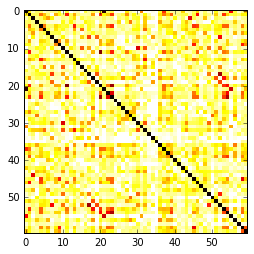

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(distances, cmap='hot', interpolation='nearest')
plt.show()

### Turn distance matrix in to coordinate, by applying MDS

In [7]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, n_init=100, max_iter=1000, n_jobs=4)
coordinates_2d = embedding.fit_transform(distances)

/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


### Do clustering to emphasise different specialities

In [15]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3, n_jobs=4).fit(coordinates_2d).labels_

### Plot it

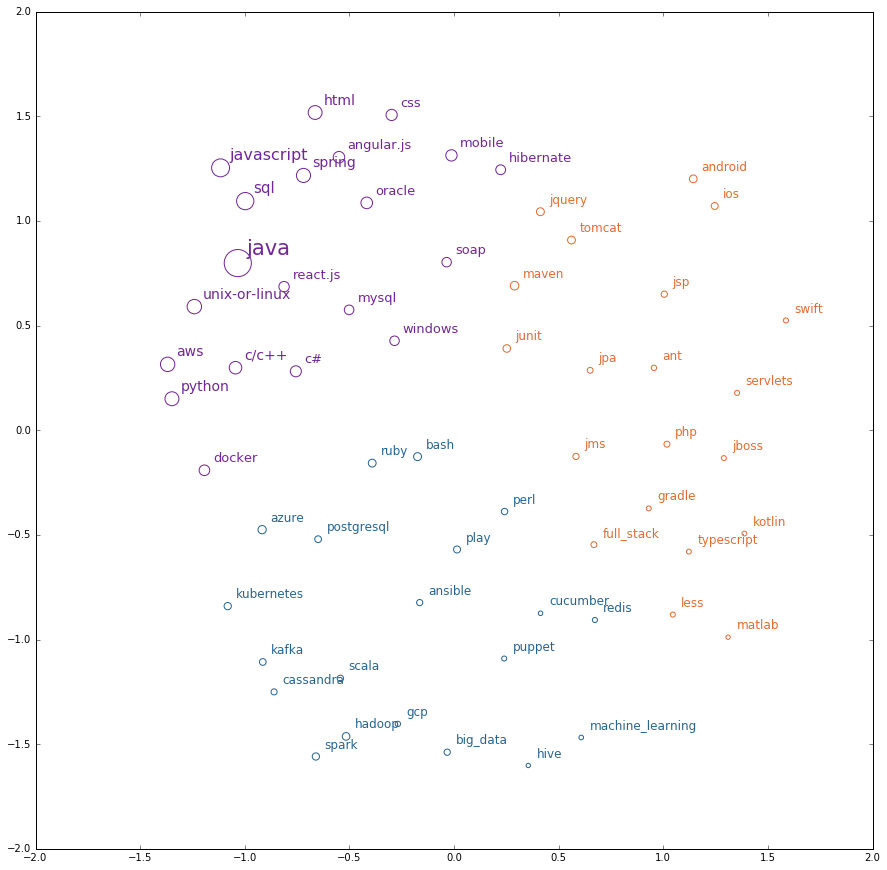

In [19]:
import matplotlib.pyplot as plt
#%matplotlib osx
%matplotlib inline

def occurance_prctg(i, coocurance_matrix, n_documents):
    return coocurance_matrix[i, i] / float(n_documents)

def font_size(prctg):
    return 12 + int(prctg * 10)

cluster_color = ['#722596', '#E26B2F', '#266391']

plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')

labels = vectorizer.get_feature_names()

for i, label in enumerate(labels):
    
    occ = occurance_prctg(i, ccrs_X, N_DOCUMENTS)
    
    color = cluster_color[clusters[i]]

    x = coordinates_2d[:, 0][i]
    y = coordinates_2d[:, 1][i]
    plt.scatter(x, y, s=750*occ, marker='o', edgecolor=color, facecolors='none')
    plt.text(x + 0.04, y + 0.04, label, fontsize=font_size(occ), color=color)
plt.show()

In [10]:
'''
from mpl_toolkits.mplot3d import Axes3D
%matplotlib osx
#%matplotlib inline

fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax = Axes3D(fig)

embedding = MDS(n_components=3, n_init=20, max_iter=500, n_jobs=4)
coordinates_3d = embedding.fit_transform(distances)
coordinates_3d

labels = vectorizer.get_feature_names()

for i, label in enumerate(labels):
    
    occ = occurance_prctg(i, ccrs_X, N_DOCUMENTS)
    if occ < 0.05:
        continue
    
    x = coordinates_3d[:, 0][i]
    y = coordinates_3d[:, 1][i]
    z = coordinates_3d[:, 2][i]
    ax.scatter(x, y, z, marker='x', color='red')
    ax.text(x + 0.01, y + 0.01, z + 0.01, label, fontsize=15)
plt.show()
'''


"\nfrom mpl_toolkits.mplot3d import Axes3D\n%matplotlib osx\n#%matplotlib inline\n\nfig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')\nax = Axes3D(fig)\n\nembedding = MDS(n_components=3, n_init=20, max_iter=500, n_jobs=4)\ncoordinates_3d = embedding.fit_transform(distances)\ncoordinates_3d\n\nlabels = vectorizer.get_feature_names()\n\nfor i, label in enumerate(labels):\n    \n    occ = occurance_prctg(i, ccrs_X, N_DOCUMENTS)\n    if occ < 0.05:\n        continue\n    \n    x = coordinates_3d[:, 0][i]\n    y = coordinates_3d[:, 1][i]\n    z = coordinates_3d[:, 2][i]\n    ax.scatter(x, y, z, marker='x', color='red')\n    ax.text(x + 0.01, y + 0.01, z + 0.01, label, fontsize=15)\nplt.show()\n"